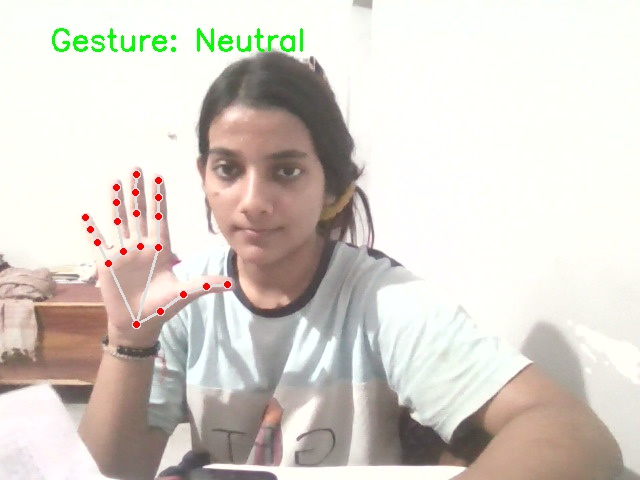

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# Install required libraries (use this in a separate cell or terminal, not in the script)
# !pip install opencv-python mediapipe pyautogui keyboard pygame

# Import necessary libraries
import cv2
import mediapipe as mp
import pyautogui
import numpy as np
import time
from IPython.display import display, Image, clear_output

# Configure pyautogui
pyautogui.FAILSAFE = True
pyautogui.PAUSE = 0.15

# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

# Initialize webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")

# Gesture detection variables
prev_index_x = None
prev_index_y = None
movement_threshold = 0.05
3
def detect_gesture(landmarks):
    global prev_index_x, prev_index_y

    # Get key landmarks
    wrist = landmarks[0]
    index_tip = landmarks[8]
    thumb_tip = landmarks[4]
    middle_tip = landmarks[12]
    ring_tip = landmarks[16]
    pinky_tip = landmarks[20]

    # Calculate distances for gesture detection
    index_to_middle = np.sqrt((index_tip.x - middle_tip.x)**2 + (index_tip.y - middle_tip.y)**2)
    fingers_spread = index_to_middle > 0.1
    open_palm = (
        fingers_spread and
        np.sqrt((middle_tip.x - ring_tip.x)**2 + (middle_tip.y - ring_tip.y)**2) > 0.1 and
        np.sqrt((ring_tip.x - pinky_tip.x)**2 + (ring_tip.y - pinky_tip.y)**2) > 0.1
    )

    if open_palm:
        return "Open Palm"

    if prev_index_x is None or prev_index_y is None:
        prev_index_x, prev_index_y = index_tip.x, index_tip.y
        return "Neutral"

    # Calculate movement deltas
    delta_x = index_tip.x - prev_index_x
    delta_y = index_tip.y - prev_index_y
    prev_index_x, prev_index_y = index_tip.x, index_tip.y

    # Detect gestures based on movement
    if abs(delta_x) > movement_threshold or abs(delta_y) > movement_threshold:
        if abs(delta_x) > abs(delta_y):  # Horizontal movement
            if delta_x < -movement_threshold:
                return "Left Tilt"
            elif delta_x > movement_threshold:
                return "Right Tilt"
        else:  # Vertical movement
            if delta_y < -movement_threshold:
                return "Open Hand"
            elif delta_y > movement_threshold:
                return "Slide"

    return "Neutral"

# Main loop
print("Click the Subway Surfers window (Poki) to focus it. You have 5 seconds.")
time.sleep(10)

last_gesture = "Neutral"
frame_count = 0
max_frames = 50000

try:
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame.")
            break

        # Flip and process the frame
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect hands
        results = hands.process(rgb_frame)

        gesture = "Neutral"
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw hand landmarks
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Detect gesture
                gesture = detect_gesture(hand_landmarks.landmark)

                # Perform actions based on gesture
                if gesture != last_gesture:
                    if gesture == "Open Hand":
                        pyautogui.press('up')
                    elif gesture == "Slide":
                        pyautogui.press('down')
                    elif gesture == "Left Tilt":
                        pyautogui.press('left')
                    elif gesture == "Right Tilt":
                        pyautogui.press('right')
                    elif gesture == "Open Palm":
                        pyautogui.press('space')

                last_gesture = gesture

        # Display gesture on the frame
        cv2.putText(frame, f"Gesture: {gesture}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Encode and display the frame
        ret, buffer = cv2.imencode('.jpg', frame)
        frame_bytes = buffer.tobytes()

        clear_output(wait=True)
        display(Image(data=frame_bytes))

        frame_count += 10
        time.sleep(0.10)

except KeyboardInterrupt:
    print("Stopped by user.")
 
finally:
     cap.release()
     cv2.destroyAllWindows()

In [ ]:
import pygame

# Initialize Pygame
pygame.init()

# Set up game window
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Pong Game")

# Colors and variables
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BALL_RADIUS = 10
PADDLE_WIDTH = 10
PADDLE_HEIGHT = 100

ball_x, ball_y = WIDTH // 2, HEIGHT // 2
ball_dx, ball_dy = 5, 5

paddle1_y, paddle2_y = HEIGHT // 2 - PADDLE_HEIGHT // 2, HEIGHT // 2 - PADDLE_HEIGHT // 2
paddle_speed = 6

# Game loop
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Move paddles
    keys = pygame.key.get_pressed()
    if keys[pygame.K_w]:  # Player 1 up
        paddle1_y -= paddle_speed
    if keys[pygame.K_s]:  # Player 1 down
        paddle1_y += paddle_speed
    if keys[pygame.K_UP]:  # Player 2 up
        paddle2_y -= paddle_speed
    if keys[pygame.K_DOWN]:  # Player 2 down
        paddle2_y += paddle_speed

    # Ball movement
    ball_x += ball_dx
    ball_y += ball_dy

    # Ball collision with walls
    if ball_y - BALL_RADIUS <= 0 or ball_y + BALL_RADIUS >= HEIGHT:
        ball_dy = -ball_dy

    # Ball collision with paddles
    if (ball_x - BALL_RADIUS <= PADDLE_WIDTH and paddle1_y <= ball_y <= paddle1_y + PADDLE_HEIGHT) or \
       (ball_x + BALL_RADIUS >= WIDTH - PADDLE_WIDTH and paddle2_y <= ball_y <= paddle2_y + PADDLE_HEIGHT):
        ball_dx = -ball_dx

    # Draw everything
    screen.fill(BLACK)
    pygame.draw.rect(screen, WHITE, (0, paddle1_y, PADDLE_WIDTH, PADDLE_HEIGHT))
    pygame.draw.rect(screen, WHITE, (WIDTH - PADDLE_WIDTH, paddle2_y, PADDLE_WIDTH, PADDLE_HEIGHT))
    pygame.draw.circle(screen, WHITE, (ball_x, ball_y), BALL_RADIUS)
    pygame.display.flip()

    # Frame rate
    pygame.time.Clock().tick(60)

pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
